<a href="https://colab.research.google.com/github/parvvaresh/Handwritten-Persian-numeral-recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import struct
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader



In [3]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24 (from 1)
Receiving objects: 100% (24/24), 6.34 MiB | 11.96 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
 cd HodaDatasetReader

/content/HodaDatasetReader


In [49]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=float)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=float)
    else:
        Y = Y.astype(dtype=float)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

################################################################################

Reading Train 60000.cdb ...
Reading Test 20000.cdb ...
Reading RemainingSamples.cdb ...

type(train_images):  <class 'list'>
len(train_images):  60000

type(train_labels):  <class 'list'>
len(train_labels):  60000

----------------------------------------

type(train_images[ 0 ]): <class 'numpy.ndarray'>
train_images[ 0 ].dtype: uint8
train_images[ 0 ].min(): 0
train_images[ 0 ].max(): 255
train_images[ 0 ].shape = (HEIGHT, WIDTH): (27, 20)

type(train_labels[ 0 ]): <class 'int'>
train_labels[ 0 ]: 6

----------------------------------------

type(train_images[ 1 ]): <class 'numpy.ndarray'>
train_images[ 1 ].dtype: uint8
train_images[ 1 ].min(): 0
train_images[ 1 ].max(): 255
train_images[ 1 ].shape = (HEIGHT, WIDTH): (20, 21)

type(train_labels[ 1 ]): <class 'int'>
train_labels[ 1 ]: 5

----------------------------------------

type(train_images[ 2 ]): <class 'numpy.ndarray'>
train_images[ 2 ].dtype: uin

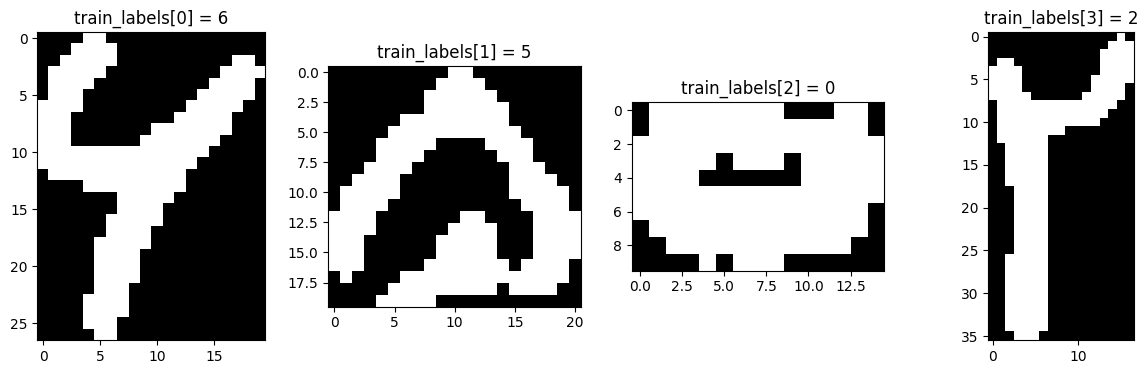

################################################################################

Reading train dataset (Train 60000.cdb)...
Reading test dataset (Test 20000.cdb)...
Reading remaining samples dataset (RemainingSamples.cdb)...

type(X_train):  <class 'numpy.ndarray'>
X_train.dtype: float64
X_train.shape: (reshape=True),  (60000, 1024)

type(Y_train):  <class 'numpy.ndarray'>
Y_train.dtype: float64
Y_train.shape: (one_hot=False),  (60000,)

type(X_test):  <class 'numpy.ndarray'>
X_test.dtype: float64
X_test.shape: (reshape=False),  (20000, 32, 32, 1)

type(Y_test):  <class 'numpy.ndarray'>
Y_test.dtype: float64
Y_test.shape: (one_hot=True),  (20000, 10)

type(X_remaining):  <class 'numpy.ndarray'>
X_remaining.dtype: float64
X_remaining.shape: (reshape=True),  (22352, 1024)

type(Y_remaining):  <class 'numpy.ndarray'>
Y_remaining.dtype: float64
Y_remaining.shape: (one_hot=True),  (22352, 10)

----------------------------------------

type(X_train[ 0 ]): <class 'numpy.ndarray'>
X_train[ 0 

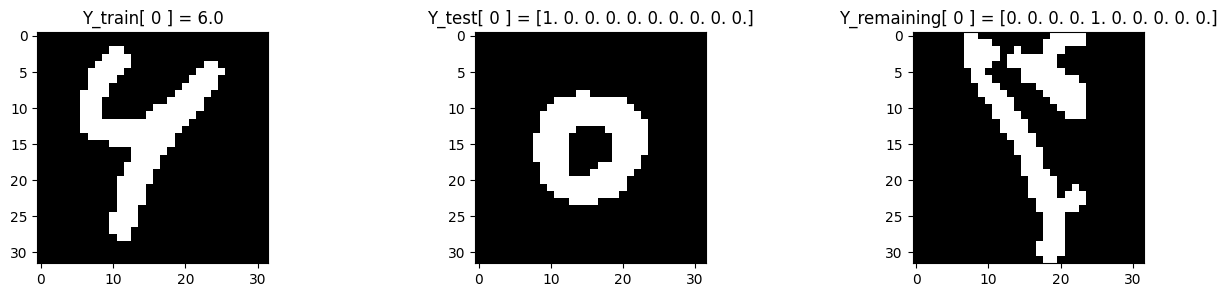

################################################################################



In [50]:
# *-* coding: utf-8 *-*

print('################################################################################')
print()

# type(train_images):  <class 'list'>
# len(train_images):  60000
#
# type(train_images[ i ]): <class 'numpy.ndarray'>
# train_images[ i ].dtype: uint8
# train_images[ i ].min(): 0
# train_images[ i ].max(): 255
# train_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(train_labels):  <class 'list'>
# len(train_labels):  60000
#
# type(train_labels[ i ]): <class 'int'>
# train_labels[ i ]: 0...9
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('./DigitDB/Train 60000.cdb')


# type(test_images):  <class 'list'>
# len(test_images):  20000
#
# type(test_images[ i ]): <class 'numpy.ndarray'>
# test_images[ i ].dtype: uint8
# test_images[ i ].min(): 0
# test_images[ i ].max(): 255
# test_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(test_labels):  <class 'list'>
# len(test_labels):  20000
#
# type(test_labels[ i ]): <class 'int'>
# test_labels[ i ]: 0...9
print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb('./DigitDB/Test 20000.cdb')


# type(remaining_images):  <class 'list'>
# len(remaining_images):  22352
#
# type(remaining_images[ i ]): <class 'numpy.ndarray'>
# remaining_images[ i ].dtype: uint8
# remaining_images[ i ].min(): 0
# remaining_images[ i ].max(): 255
# remaining_images[ i ].shape: (HEIGHT, WIDTH)
#
# type(remaining_labels):  <class 'list'>
# len(remaining_labels):  22352
#
# type(remaining_labels[ i ]): <class 'int'>
# remaining_labels[ i ]: 0...9
print('Reading RemainingSamples.cdb ...')
remaining_images, remaining_labels = read_hoda_cdb('./DigitDB/RemainingSamples.cdb')

print()

# ******************************************************************************

print('type(train_images): ', type(train_images))
print('len(train_images): ', len(train_images))
print()

print('type(train_labels): ', type(train_labels))
print('len(train_labels): ', len(train_labels))
print()

fig = plt.figure(figsize=(15, 4))
for i in range(4):

    print('----------------------------------------')
    print()

    print('type(train_images[', i, ']):', type(train_images[i]))
    print('train_images[', i, '].dtype:', train_images[i].dtype)
    print('train_images[', i, '].min():', train_images[i].min())
    print('train_images[', i, '].max():', train_images[i].max())
    print('train_images[', i, '].shape = (HEIGHT, WIDTH):', train_images[i].shape)
    print()

    print('type(train_labels[', i, ']):', type(train_labels[i]))
    print('train_labels[', i, ']:', train_labels[i])
    print()

    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels[i]))
    plt.imshow(train_images[i], cmap='gray')

plt.show()

print('################################################################################')
print()

# type(X_train):  <class 'numpy.ndarray'>
# X_train.dtype: float32
# X_train.shape: (reshape=True),  (60000, 1024)
#
# type(X_train[ i ]): <class 'numpy.ndarray'>
# X_train[ i ].dtype: float32
# X_train[ i ].min(): 0.0
# X_train[ i ].max(): 1.0
# X_train[ i ].shape = (HEIGHT*WIDTH,): (reshape=True),  (1024,)
#
# type(Y_train):  <class 'numpy.ndarray'>
# Y_train.dtype: float32
# Y_train.shape: (one_hot=False),  (60000,)
#
# type(Y_train[ i ]): <class 'numpy.float32'>
# Y_train[ i ].dtype: float32
# Y_train[ i ]: (one_hot=False),  0...9
print('Reading train dataset (Train 60000.cdb)...')
X_train, Y_train = read_hoda_dataset(dataset_path='./DigitDB/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)


# type(X_test):  <class 'numpy.ndarray'>
# X_test.dtype: float32
# X_test.shape: (reshape=False),  (20000, 32, 32, 1)
#
# type(X_test[ i ]): <class 'numpy.ndarray'>
# X_test[ i ].dtype: float32
# X_test[ i ].min(): 0.0
# X_test[ i ].max(): 1.0
# X_test[ i ].shape = (HEIGHT, WIDTH, CHANNEL): (reshape=False),  (32, 32, 1)
#
# type(Y_test):  <class 'numpy.ndarray'>
# Y_test.dtype: float32
# Y_test.shape: (one_hot=True),  (20000, 10)
#
# type(Y_test[ i ]): <class 'numpy.ndarray'>
# Y_test[ i ].dtype: float32
# Y_test[ i ].min(): 0.0
# Y_test[ i ].max(): 1.0
# Y_test[ 0 ]: (one_hot=True),  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
print('Reading test dataset (Test 20000.cdb)...')
X_test, Y_test = read_hoda_dataset(dataset_path='./DigitDB/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=True,
                              reshape=False)


# type(X_remaining):  <class 'numpy.ndarray'>
# X_remaining.dtype: float32
# X_remaining.shape: (reshape=True),  (22352, 1024)
#
# type(X_remaining[ i ]): <class 'numpy.ndarray'>
# X_remaining[ i ].dtype: float32
# X_remaining[ i ].min(): 0.0
# X_remaining[ i ].max(): 1.0
# X_remaining[ i ].shape = (HEIGHT*WIDTH,): (reshape=True),  (1024,)
#
# type(Y_remaining):  <class 'numpy.ndarray'>
# Y_remaining.dtype: float32
# Y_remaining.shape: (one_hot=True),  (22352, 10)
#
# type(Y_remaining[ i ]): <class 'numpy.ndarray'>
# Y_remaining[ i ].dtype: float32
# Y_remaining[ i ].min(): 0.0
# Y_remaining[ i ].max(): 1.0
# Y_remaining[ 0 ]: (one_hot=True),  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
print('Reading remaining samples dataset (RemainingSamples.cdb)...')
X_remaining, Y_remaining = read_hoda_dataset('./DigitDB/RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=True,
                                             reshape=True)

print()

# ******************************************************************************

print('type(X_train): ', type(X_train))
print('X_train.dtype:', X_train.dtype)
print('X_train.shape: (reshape=True), ', X_train.shape)
print()

print('type(Y_train): ', type(Y_train))
print('Y_train.dtype:', Y_train.dtype)
print('Y_train.shape: (one_hot=False), ', Y_train.shape)
print()

print('type(X_test): ', type(X_test))
print('X_test.dtype:', X_test.dtype)
print('X_test.shape: (reshape=False), ', X_test.shape)
print()

print('type(Y_test): ', type(Y_test))
print('Y_test.dtype:', Y_test.dtype)
print('Y_test.shape: (one_hot=True), ', Y_test.shape)
print()

print('type(X_remaining): ', type(X_remaining))
print('X_remaining.dtype:', X_remaining.dtype)
print('X_remaining.shape: (reshape=True), ', X_remaining.shape)
print()

print('type(Y_remaining): ', type(Y_remaining))
print('Y_remaining.dtype:', Y_remaining.dtype)
print('Y_remaining.shape: (one_hot=True), ', Y_remaining.shape)
print()

fig = plt.figure(figsize=(16, 3))

print('----------------------------------------')
print()

print('type(X_train[ 0 ]):', type(X_train[0]))
print('X_train[ 0 ].dtype:', X_train[0].dtype)
print('X_train[ 0 ].min():', X_train[0].min())
print('X_train[ 0 ].max():', X_train[0].max())
print('X_train[ 0 ].shape = (HEIGHT*WIDTH,): (reshape=True), ', X_train[0].shape)
print()

print('type(Y_train[ 0 ]):', type(Y_train[0]))
print('Y_train[ 0 ].dtype:', Y_train[0].dtype)
print('Y_train[ 0 ]: (one_hot=False), ', Y_train[0])
print()

fig.add_subplot(1, 3, 1)
plt.title('Y_train[ 0 ] = ' + str(Y_train[0]))
plt.imshow(X_train[0].reshape([32, 32]), cmap='gray')

print('----------------------------------------')
print()

print('type(X_test[ 0 ]):', type(X_test[0]))
print('X_test[ 0 ].dtype:', X_test[0].dtype)
print('X_test[ 0 ].min():', X_test[0].min())
print('X_test[ 0 ].max():', X_test[0].max())
print('X_test[ 0 ].shape = (HEIGHT, WIDTH, CHANNEL): (reshape=False), ', X_test[0].shape)
print()

print('type(Y_test[ 0 ]):', type(Y_test[0]))
print('Y_test[ 0 ].dtype:', Y_test[0].dtype)
print('Y_test[ 0 ].min():', Y_test[0].min())
print('Y_test[ 0 ].max():', Y_test[0].max())
print('Y_test[ 0 ]: (one_hot=True), ', Y_test[0])
print()

fig.add_subplot(1, 3, 2)
plt.title('Y_test[ 0 ] = ' + str(Y_test[0]))
plt.imshow(X_test[0].reshape([32, 32]), cmap='gray')

print('----------------------------------------')
print()

print('type(X_remaining[ 0 ]):', type(X_remaining[0]))
print('X_remaining[ 0 ].dtype:', X_remaining[0].dtype)
print('X_remaining[ 0 ].min():', X_remaining[0].min())
print('X_remaining[ 0 ].max():', X_remaining[0].max())
print('X_remaining[ 0 ].shape = (HEIGHT*WIDTH,): (reshape=True), ', X_remaining[0].shape)
print()

print('type(Y_remaining[ 0 ]):', type(Y_remaining[0]))
print('Y_remaining[ 0 ].dtype:', Y_remaining[0].dtype)
print('Y_remaining[ 0 ].min():', Y_remaining[0].min())
print('Y_remaining[ 0 ].max():', Y_remaining[0].max())
print('Y_remaining[ 0 ]: (one_hot=True), ', Y_remaining[0])
print()

fig.add_subplot(1, 3, 3)
plt.title('Y_remaining[ 0 ] = ' + str(Y_remaining[0]))
plt.imshow(X_remaining[0].reshape([32, 32]), cmap='gray')

plt.show()

print('################################################################################')
print()

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

In [52]:


train_images = [img.numpy() if isinstance(img, torch.Tensor) else img for img in train_images]

target_size = (32, 32)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(target_size),
    transforms.ToTensor()
])

train_images = [transform(img) for img in train_images]

train_labels = torch.tensor(train_labels, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = CustomDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


Epoch 1, Loss: 0.10392121438220986
Epoch 2, Loss: 0.024269476583355844
Epoch 3, Loss: 0.01437545373655841
Epoch 4, Loss: 0.010433970510905001
Epoch 5, Loss: 0.008839380769544875
Epoch 6, Loss: 0.005599637767053011
Epoch 7, Loss: 0.004672296095113663
Epoch 8, Loss: 0.003916079995683901
Epoch 9, Loss: 0.0027997601193277145
Epoch 10, Loss: 0.002555600000277915


In [55]:
test_images = [img.numpy() if isinstance(img, torch.Tensor) else img for img in test_images]

target_size = (32, 32)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(target_size),
    transforms.ToTensor()
])

test_images = [transform(img) for img in test_images]

test_labels = torch.tensor(test_labels, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

test_dataset = CustomDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [56]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate(model, test_loader, device)


Accuracy on test set: 99.33%
